/var/folders/b0/3m9ppxz93zl2xj3hppxlrzbw0000gn/T/ipykernel_30082/3820119532.py:32: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [b, a, sigma]


/opt/anaconda3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/anaconda3/envs/bayes/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 34 seconds.
/opt/anaconda3/envs/bayes/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      0.993  0.102   0.804    1.183      0.001      0.0   22372.0   14101.0   
b      2.000  0.105   1.800    2.192      0.001      0.0   22940.0   14440.0   
sigma  0.708  0.075   0.575    0.853      0.001      0.0   20862.0   13313.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0  


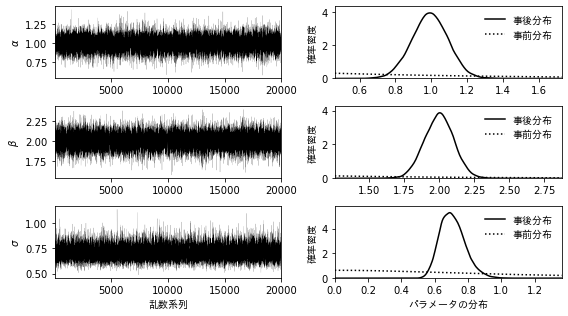

In [4]:
import numpy as np
import scipy.stats as st
import pymc3 as pm
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

FontPath = '/Users/knysmchr/Downloads/IPAexfont00301/ipaexg.ttf'
jpfont = FontProperties(fname=FontPath)

# 回帰モデルからのデータ生成
n = 50
np.random.seed(99)
u = st.norm.rvs(scale=0.7, size=n)
x = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
y = 1.0 + 2.0 * x + u
# 回帰モデルの係数と誤差項の分散の事後分布の設定(ラプラス＋半コーシー分布)
b0 = np.zeros(2)
tau_coef = np.ones(2)
tau_sigma = 1.0
regression_laplace_halfcauchy = pm.Model()
with regression_laplace_halfcauchy:
    sigma = pm.HalfCauchy('sigma', beta=tau_sigma)
    a = pm.Laplace('a', mu=b0[0], b=tau_coef[0])
    b = pm.Laplace('b', mu=b0[1], b=tau_coef[1])
    y_hat = a + b * x
    likelihood = pm.Normal('y', mu=y_hat, sd=sigma, observed=y)
# 事後分布のサンプリング
n_draws = 5000
n_chains = 4
n_tune = 1000
with regression_laplace_halfcauchy:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)
print(pm.summary(trace))
# 事後分布のグラフの作成
k = b0.size
param_names = ['a', 'b', 'sigma']
labels = ['$\\alpha$', '$\\beta$', '$\\sigma$']
fig, ax = plt.subplots(k+1, 2, num=1, figsize=(8, 1.5*(k+1)), facecolor='w')
for index in range(k+1):
    mc_trace = trace[param_names[index]]
    if index < k:
        x_min = mc_trace.min() - 0.2 * np.abs(mc_trace.min())
        x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.laplace.pdf(x, loc=b0[index], scale=tau_coef[index])
    else:
        x_min = 0.0
        x_max = mc_trace.max() + 0.2 * np.abs(mc_trace.max())
        x = np.linspace(x_min, x_max, 250)
        prior = st.halfcauchy.pdf(x, scale=tau_sigma)
        ax[index, 0].set_xlabel('乱数系列', fontproperties=jpfont)
        ax[index, 1].set_xlabel('パラメータの分布', fontproperties=jpfont)
    ax[index, 0].plot(mc_trace, 'k-', linewidth=0.1)
    ax[index, 0].set_xlim(1, n_draws*n_chains)
    ax[index, 0].set_ylabel(labels[index], fontproperties=jpfont)
    posterior = st.gaussian_kde(mc_trace).evaluate(x)
    ax[index, 1].plot(x, posterior, 'k-', label='事後分布')
    ax[index, 1].plot(x, prior, 'k:', label='事前分布')
    ax[index, 1].set_xlim(x_min, x_max)
    ax[index, 1].set_ylim(0, 1.1*posterior.max())
    ax[index, 1].set_ylabel('確率密度', fontproperties=jpfont)
    ax[index, 1].legend(loc='best', frameon=False, prop=jpfont)
plt.tight_layout()
plt.savefig('pybayes_mcmc_reg_ex4.png', dpi=300)
plt.show()